In [211]:
from datetime import datetime
import csv
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from constants import DATA_DIR, MAX_TRAJ_STEPS, EMBED_DIM
from visualize_data import calculate_endpoint

In [65]:
def process_data(data_dir=DATA_DIR):
    exclude_indexes_list = [4, 6, 11, 12, 13, 14, 15, 16, 22, 23, 25, 31]
    safe_data_index_range = (1, 21)
    unsafe_data_index_range = (21, 35)
    num_data = unsafe_data_index_range[1] - safe_data_index_range[0] + 1 - len(exclude_indexes_list)
    
    X = np.zeros((num_data, 1000, EMBED_DIM + 1), dtype=np.float64) # + 1 for timestamp
    Y = np.zeros((num_data, 1))
    seen_experiments = []
    
    with open(data_dir, mode ='r')as file:
        reader = csv.DictReader(file)
        correct_e_id = 0
        
        for row in reader:
            keys = list(row.values())
            
            e_id, timestamp = int(keys[0]), np.float64(keys[1])
            
            
            if e_id in exclude_indexes_list:
                if e_id not in seen_experiments:
                    correct_e_id += 1

            elif e_id not in exclude_indexes_list:
                if e_id not in seen_experiments:
                    traj_index = 0
                else:
                    traj_index += 1
                
            seen_experiments.append(e_id)
            
            if e_id in exclude_indexes_list:
                continue

            x, y, z = np.float64(keys[2]), np.float64(keys[3]), np.float64(keys[4]),
            a, b, c, d = np.float64(keys[5]), np.float64(keys[6]), np.float64(keys[7]), np.float64(keys[8])
            
            X[e_id-1-correct_e_id, traj_index, :] = np.array([[timestamp, x, y, z, a, b, c, d, 1]]) # cup type is 1
            
            if e_id in safe_data_index_range:
                Y[e_id-1-correct_e_id] = 0
            else:
                Y[e_id-1-correct_e_id] = 1
    return X, Y

In [196]:
X, Y = process_data()


(23, 1000, 9)


In [197]:
def get_biggest_trajectory(X):
    max_T_e_id = 0
    max_zero_index = 0
    for e_id in range(X.shape[0]):
        first_zero_index = np.argmin(X[e_id, :, 0])
        if first_zero_index > max_zero_index:
            max_zero_index = first_zero_index
            max_T_e_id = e_id
    t2 = datetime.fromtimestamp(X[max_T_e_id, max_zero_index - 1, 0])
    t1 = datetime.fromtimestamp(X[max_T_e_id, 0, 0])
    return t2 - t1, max_T_e_id, max_zero_index

In [212]:
max_T, max_e_id, max_zero_index = get_biggest_trajectory(X)
print(max_T, max_e_id, max_zero_index)

0:00:08.383343 0 994
8


In [207]:
def fix_trajectory(X):
    frame_rate = 120
    dt = int(frame_rate/10)
    traj_lenght = int(max_zero_index/dt) + 1
    X_new = np.zeros((X.shape[0], traj_lenght, EMBED_DIM), dtype=np.float64)
    X_new[:, :, :] = X[:, 0:max_zero_index:dt, 1:]
    return X_new

In [209]:
X_new = fix_trajectory(X)
print('X shape: ', X.shape)
print('X_new shape: ', X_new.shape)

X shape:  (23, 1000, 9)
X_new shape:  (23, 83, 8)


In [236]:
def get_start_and_end_points(X, e_id):
    start_points = np.empty((0, 3), np.float64)
    end_points = np.empty((0, 3), np.float64)
    
    for step in range(X.shape[1]):
        x, y, z = X[e_id, step, 0], X[e_id, step, 1], X[e_id, step, 2]
        a, b, c, d = X[e_id, step, 3], X[e_id, step, 4], X[e_id, step, 5], X[e_id, step, 6]
        
        all_zeros = not np.any(X[e_id, step, :])
        if all_zeros:
            break
        
        start_point = np.array([[x, y, z]])
        end_point = calculate_endpoint(start_point, a, b, c, d)
        start_points = np.append(start_points, start_point, axis=0)
        end_points = np.append(end_points, end_point, axis=0)

    return start_points, end_points

In [238]:
start_points, end_points = get_start_and_end_points(X, 0)

In [239]:
def plot(X, e_id, arrows_lenght):
    start_points, end_points = get_start_and_end_points(X, e_id)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.quiver(start_points[:, 0], start_points[:, 1], start_points[:, 2],
                end_points[:, 0], end_points[:, 1], end_points[:, 2],
                length = arrows_lenght, normalize = True)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

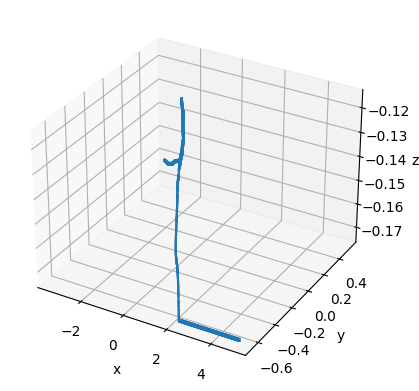

In [241]:
plot(X, 0, 0.01)